In [1]:
from cnmodel import populations
from cnmodel.util import sound, random_seed
from cnmodel.protocols import Protocol
from collections import OrderedDict
import os, sys, time
import pickle
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from neuron import h
import multiprocessing as mp
from scipy.signal import savgol_filter
import yaml
import seaborn as sns
import itertools

--No graphics will be displayed.
[439167] Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[439167] Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
[439167] NumExpr defaulting to 16 threads.


In [2]:
sgc_pop = populations.SGC()
sgc_cfs = sgc_pop._get_cf_array(species='mouse')
b = (sgc_cfs[-1] - sgc_cfs[0]) / np.log(sgc_cfs[-1] / sgc_cfs[0])
a = sgc_cfs[0] - b * np.log(sgc_cfs[0])
sgc_cfs_log = a + b * np.log(sgc_cfs)

## Functions

In [3]:
def get_spontaneous_rate(cell_type, results, stimpar, pyr_ids=None):
    spont_spikes = []
    spont_times = []

    for stim, iterations in list(results.values()):
        rep_spont_spikes = []
        for cell, vec in iterations.items():
            if isinstance(cell, str):
                continue
            save_rate = True if (('sgc' in cell_type) or (('pyr' in cell_type) and (cell[1] in pyr_ids))) else False
            if (cell_type in cell[0]) and save_rate:
                spikes = np.array(vec[1])
                # if len(spikes) > 0:
                rep_spont_spikes.append(((spikes >= stimpar['baseline'][0]) * (spikes < stimpar['baseline'][1])).sum())
                # spont_times.append(stimpar['baseline'][1] - stimpar['baseline'][0])
        spont_spikes.append(rep_spont_spikes)

    spont_spikes = np.mean(spont_spikes, axis=0)

    spont_rates = np.array(spont_spikes) / (stimpar['baseline'][1] - stimpar['baseline'][0])
    return spont_rates

In [ ]:
def get_cell_nspikes(cell_type, results, response, pyr_ids=None):
    n_spikes = []
    cell_ids = []

    for stim, iterations in results.values():
        rep_n_spikes = []
        rep_cell_ids = []
        for cell, vec in iterations.items():
            if isinstance(cell, str):
                continue
            save_rate = True if ('sgc' in cell_type) or (('pyr' in cell_type) and (cell[1] in pyr_ids)) else False
            if (cell_type in cell[0]) and save_rate:
                spikes = np.array(vec[1])
                num_spikes = ((spikes >= response[0]) & (spikes < response[1])).sum()
                rep_n_spikes.append(num_spikes)
                rep_cell_ids.append(cell[1])

        n_spikes.append(rep_n_spikes)
        cell_ids.append(rep_cell_ids)

    n_spikes = np.mean(n_spikes, axis=0)

    return cell_ids[0], np.array(n_spikes)

In [3]:
def get_rate_level_curve(cell_type, results, levels, response, pyr_id):

    rate_levels = {int(level): [] for level in levels}
    cell_ids = []

    for stim, (_, iterations) in results.items():

        level = stim[1]
        n_rep = stim[2]
        # rate_levels[level] = []
        rep_n_spikes = []
        rep_cell_ids = []

        spikes = iterations[(cell_type, pyr_id)][1]
        # spikes = np.array(vec[1])
        num_spikes = ((spikes >= response[0]) & (spikes < response[1])).sum()
        rate_levels[level].append(num_spikes)

        # for cell, vec in iterations.items():
        #     if isinstance(cell, str):
        #         continue
        #     # save_rate = True if ('sgc' in cell_type) or (('pyr' in cell_type) and (cell[1] in pyr_ids)) else False
        #     if cell[1] == pyr_id:
        #         spikes = np.array(vec[1])
        #         num_spikes = ((spikes >= response[0]) & (spikes < response[1])).sum()
        #         rep_n_spikes.append(num_spikes)

        

        # temp = 6
    for level, n_spikes in rate_levels.items():

        rate_levels[level] = np.mean(n_spikes)
        
    return rate_levels


        

In [5]:
def get_cell_msfs(cell_type, results, response, pyr_ids=None):
    msfs = []
    cell_ids = []

    for stim, iterations in results.values():
        rep_msfs = []
        rep_cell_ids = []
        for cell, vec in iterations.items():
            if isinstance(cell, str):
                continue
            save_rate = True if ('sgc' in cell_type) or (('pyr' in cell_type) and (cell[1] in pyr_ids)) else False
            if (cell_type in cell[0]) and save_rate:
                spikes = np.array(vec[1])
                resp_spikes = spikes[(spikes >= response[0]) & (spikes < response[1])]
                num_spikes = len(resp_spikes)
                num_isi = num_spikes - 1 if num_spikes > 0 else 0
                msf = num_isi / (spikes[-1] - spikes[0]) * 1000 if num_spikes > 1 else 1
                rep_msfs.append(msf)
                rep_cell_ids.append(cell[1])

        msfs.append(rep_msfs)
        cell_ids.append(rep_cell_ids)

    msfs = np.average(msfs, axis=0)

    return cell_ids[0], np.array(msfs)

## Rate-Level Functions

In [4]:
stimpar = {
    "dur": 0.26,
    "pip": 0.1,
    "start": [0.1],
    "baseline": [50, 100],
    "response": [100, 200],
}

input_freq = 22e3
input_level = 60

In [5]:
n_cfs = 665
n_reps = 2
n_dbs = 11
levels = np.linspace(20, 100, n_dbs)

sim_flag = 'network_ds2v'

results = pickle.load(open(f'/scratch/kedoxey/dcnmodel_scratch/output/response_maps-{sim_flag}/{n_cfs}cfs_{n_dbs}dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/scratch/kedoxey/dcnmodel_scratch/output/response_maps-{sim_flag}/{n_cfs}cfs_{n_dbs}dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))

In [6]:
sim_flag = 'network_ds2v_13000loss-m1_70'
results_loss = pickle.load(open(f'/scratch/kedoxey/dcnmodel_scratch/output/response_maps-{sim_flag}/{n_cfs}cfs_{n_dbs}dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band_loss = pickle.load(open(f'/scratch/kedoxey/dcnmodel_scratch/output/response_maps-{sim_flag}/{n_cfs}cfs_{n_dbs}dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))

In [7]:
pyr_ids = list(itertools.chain.from_iterable(pyr_ids_per_band.values()))
freqs = list(pyr_ids_per_band.keys())
pyr_id = pyr_ids_per_band[freqs[(np.abs(np.array(freqs)-22000)).argmin()]][0]
rate_levels = get_rate_level_curve('pyramidal', results, levels, stimpar['response'], pyr_id)

pyr_ids_loss = list(itertools.chain.from_iterable(pyr_ids_per_band_loss.values()))
freqs_loss = list(pyr_ids_per_band_loss.keys())
pyr_id_loss = pyr_ids_per_band_loss[freqs[(np.abs(np.array(freqs_loss)-22000)).argmin()]][0]
rate_levels_loss = get_rate_level_curve('pyramidal', results_loss, levels, stimpar['response'], pyr_id_loss)

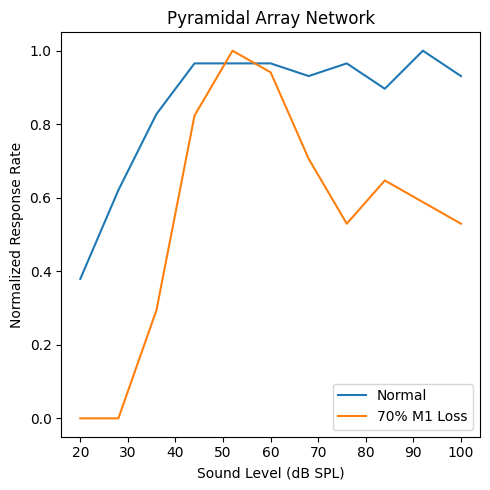

In [ ]:
rates = np.array([val for val in rate_levels.values()])
rates_loss = np.array([val for val in rate_levels_loss.values()])

fig, axs = plt.subplots(1,1,figsize=(5,5))

axs.plot(levels, rates/np.max(rates), label='Normal')
axs.plot(levels, rates_loss/np.max(rates_loss), label='70% M1 Loss')
axs.set_xlabel('Sound Level (dB SPL)')
axs.set_ylabel('Normalized Response Rate')
axs.set_title('Pyramidal Array Network')

axs.legend(loc='lower right')

fig.tight_layout()
fig.set_dpi(300)


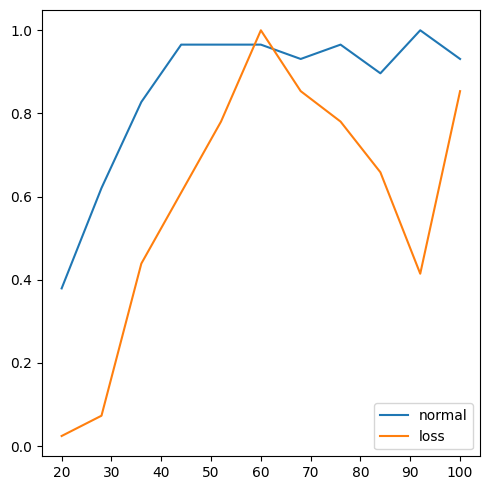

In [ ]:
rates = np.array([val for val in rate_levels.values()])
rates_loss = np.array([val for val in rate_levels_loss.values()])

fig, axs = plt.subplots(1,1,figsize=(5,5))

axs.plot(levels, rates/np.max(rates), label='Normal')
axs.plot(levels, rates_loss/np.max(rates_loss), label='50% M3 Loss')
axs.legend(loc='lower right')

fig.tight_layout()


In [ ]:
n_cfs = 665
n_reps = 2

sim_flag = 'network_ds2v'

results = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
pyr_ids = list(itertools.chain.from_iterable(pyr_ids_per_band.values()))
freqs = list(pyr_ids_per_band.keys())
pyr_spont_rates = get_spontaneous_rate('pyramidal', results, stimpar, pyr_ids)
sgc_spont_rates = get_spontaneous_rate('sgc', results, stimpar)
pyr_ids, pyr_resp_spikes = get_cell_nspikes('pyramidal', results, stimpar['response'], pyr_ids)
sgc_ids, sgc_resp_spikes = get_cell_nspikes('sgc', results, stimpar['response'])

pyr_ids, pyr_resp_msfs = get_cell_msfs('pyramidal', results, stimpar['response'], pyr_ids)
sgc_ids, sgc_resp_msfs = get_cell_msfs('sgc', results, stimpar['response'])

n_cfs = 665  # 213 or 665
loss_frac = 60
loss_version = 'm3'
results_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}_13000loss-{loss_version}_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}_13000loss-{loss_version}_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
pyr_ids_loss = list(itertools.chain.from_iterable(pyr_ids_per_band_loss.values()))
freqs_loss = list(pyr_ids_per_band_loss.keys())
pyr_spont_rates_loss = get_spontaneous_rate('pyramidal', results_loss, stimpar, pyr_ids_loss)
sgc_spont_rates_loss = get_spontaneous_rate('sgc', results_loss, stimpar)
pyr_ids_loss, pyr_resp_spikes_loss = get_cell_nspikes('pyramidal', results_loss, stimpar['response'], pyr_ids_loss)
sgc_ids_loss, sgc_resp_spikes_loss = get_cell_nspikes('sgc', results_loss, stimpar['response'])

pyr_ids_loss, pyr_resp_msfs_loss = get_cell_msfs('pyramidal', results_loss, stimpar['response'], pyr_ids_loss)
sgc_ids_loss, sgc_resp_msfs_loss = get_cell_msfs('sgc', results_loss, stimpar['response'])

## Normal vs Loss - 22kHz at 60 dB

In [6]:
stimpar = {
    "dur": 0.26,
    "pip": 0.1,
    "start": [0.1],
    "baseline": [50, 100],
    "response": [100, 200],
}

input_freq = 22e3
input_level = 60

In [7]:
n_cfs = 665
n_reps = 2

sim_flag = 'network_longerstim'

results = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
pyr_ids = list(itertools.chain.from_iterable(pyr_ids_per_band.values()))
freqs = list(pyr_ids_per_band.keys())
pyr_spont_rates = get_spontaneous_rate('pyramidal', results, stimpar, pyr_ids)
sgc_spont_rates = get_spontaneous_rate('sgc', results, stimpar)
pyr_ids, pyr_resp_spikes = get_cell_nspikes('pyramidal', results, stimpar['response'], pyr_ids)
sgc_ids, sgc_resp_spikes = get_cell_nspikes('sgc', results, stimpar['response'])

pyr_ids, pyr_resp_msfs = get_cell_msfs('pyramidal', results, stimpar['response'], pyr_ids)
sgc_ids, sgc_resp_msfs = get_cell_msfs('sgc', results, stimpar['response'])

n_cfs = 665  # 213 or 665
loss_frac = 60
loss_version = 'm3'
results_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}_13000loss-{loss_version}_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}_13000loss-{loss_version}_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
pyr_ids_loss = list(itertools.chain.from_iterable(pyr_ids_per_band_loss.values()))
freqs_loss = list(pyr_ids_per_band_loss.keys())
pyr_spont_rates_loss = get_spontaneous_rate('pyramidal', results_loss, stimpar, pyr_ids_loss)
sgc_spont_rates_loss = get_spontaneous_rate('sgc', results_loss, stimpar)
pyr_ids_loss, pyr_resp_spikes_loss = get_cell_nspikes('pyramidal', results_loss, stimpar['response'], pyr_ids_loss)
sgc_ids_loss, sgc_resp_spikes_loss = get_cell_nspikes('sgc', results_loss, stimpar['response'])

pyr_ids_loss, pyr_resp_msfs_loss = get_cell_msfs('pyramidal', results_loss, stimpar['response'], pyr_ids_loss)
sgc_ids_loss, sgc_resp_msfs_loss = get_cell_msfs('sgc', results_loss, stimpar['response'])

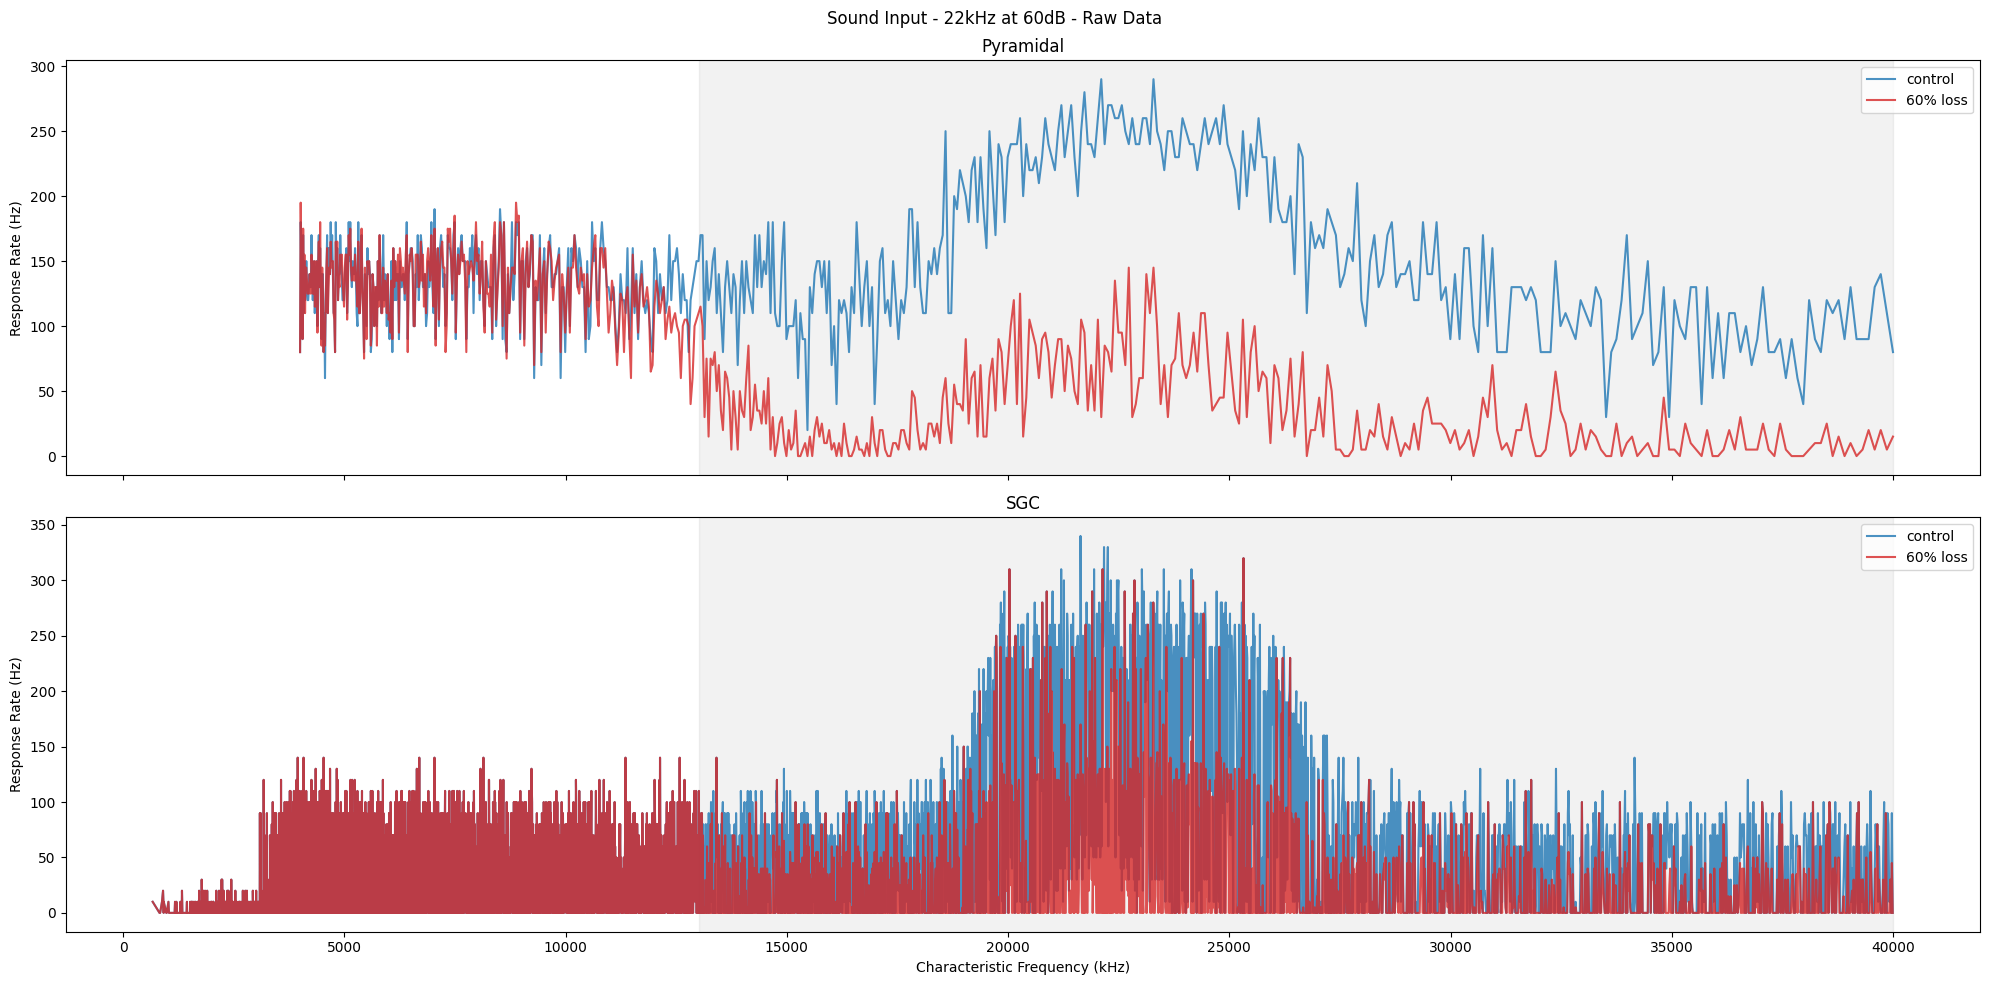

In [8]:
fig, axs = plt.subplots(2,1,figsize=(20,10), sharex=True)  #, sharey=True)
axs = axs.ravel()

data = (sgc_resp_spikes / (stimpar['response'][1] - stimpar['response'][0])*1000) - sgc_spont_rates*0
# data = sgc_resp_msfs
axs[1].plot(sgc_cfs[sgc_ids], data, color='tab:blue', zorder=13, alpha=0.8, label='control')
axs[1].set_title('SGC (control)')

data = (sgc_resp_spikes_loss / (stimpar['response'][1] - stimpar['response'][0])*1000) - sgc_spont_rates_loss*0 
# data = sgc_resp_msfs_loss
axs[1].plot(sgc_cfs[sgc_ids_loss], data, color='tab:red', zorder=13, alpha=0.8, label=f'{loss_frac}% loss')
axs[1].set_title(f"SGC")

data = (pyr_resp_spikes / (stimpar['response'][1] - stimpar['response'][0])*1000)-pyr_spont_rates*0 
# data = pyr_resp_msfs
axs[0].plot(freqs, data, color='tab:blue', zorder=13, alpha=0.8, label='control')

data = (pyr_resp_spikes_loss / (stimpar['response'][1] - stimpar['response'][0])*1000)-pyr_spont_rates_loss*0 
# data = pyr_resp_msfs_loss
axs[0].plot(freqs_loss, data, color='tab:red', zorder=13, alpha=0.8, label=f'{loss_frac}% loss')
axs[0].set_title(f'Pyramidal')

# axs[1,0].set_ylabel('Smoothed MSF')

loss_inds = np.array(freqs)[np.where(np.array(freqs) > 13e3)[0]]

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')

axs[0].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
axs[1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Response Rate (Hz)')
axs[1].set_ylabel('Response Rate (Hz)')

axs[1].set_xlabel('Characteristic Frequency (kHz)')
axs[1].set_xlabel('Characteristic Frequency (kHz)')

# fig.suptitle(f'Pyramidal Response to {input_freq}Hz at {input_level}dB (85 hearing loss starting at 13kHz)')
fig.suptitle(f"Sound Input - {round(input_freq/1000)}kHz at {input_level}dB - Raw Data")
fig.tight_layout()

## Normal vs Loss with Dstellate -> Vertical - 22kHz at 60 dB

In [9]:
stimpar = {
    "dur": 0.26,
    "pip": 0.1,
    "start": [0.1],
    "baseline": [50, 100],
    "response": [100, 200],
}

input_freq = 22e3
input_level = 60

In [10]:
n_cfs = 665
n_reps = 2

sim_flag = 'network_ds2v'

results = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
pyr_ids = list(itertools.chain.from_iterable(pyr_ids_per_band.values()))
freqs = list(pyr_ids_per_band.keys())
pyr_spont_rates = get_spontaneous_rate('pyramidal', results, stimpar, pyr_ids)
sgc_spont_rates = get_spontaneous_rate('sgc', results, stimpar)
pyr_ids, pyr_resp_spikes = get_cell_nspikes('pyramidal', results, stimpar['response'], pyr_ids)
sgc_ids, sgc_resp_spikes = get_cell_nspikes('sgc', results, stimpar['response'])

pyr_ids, pyr_resp_msfs = get_cell_msfs('pyramidal', results, stimpar['response'], pyr_ids)
sgc_ids, sgc_resp_msfs = get_cell_msfs('sgc', results, stimpar['response'])

n_cfs = 665  # 213 or 665
loss_frac = 60
loss_version = 'm3'
results_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}_13000loss-{loss_version}_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}_13000loss-{loss_version}_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
pyr_ids_loss = list(itertools.chain.from_iterable(pyr_ids_per_band_loss.values()))
freqs_loss = list(pyr_ids_per_band_loss.keys())
pyr_spont_rates_loss = get_spontaneous_rate('pyramidal', results_loss, stimpar, pyr_ids_loss)
sgc_spont_rates_loss = get_spontaneous_rate('sgc', results_loss, stimpar)
pyr_ids_loss, pyr_resp_spikes_loss = get_cell_nspikes('pyramidal', results_loss, stimpar['response'], pyr_ids_loss)
sgc_ids_loss, sgc_resp_spikes_loss = get_cell_nspikes('sgc', results_loss, stimpar['response'])

pyr_ids_loss, pyr_resp_msfs_loss = get_cell_msfs('pyramidal', results_loss, stimpar['response'], pyr_ids_loss)
sgc_ids_loss, sgc_resp_msfs_loss = get_cell_msfs('sgc', results_loss, stimpar['response'])

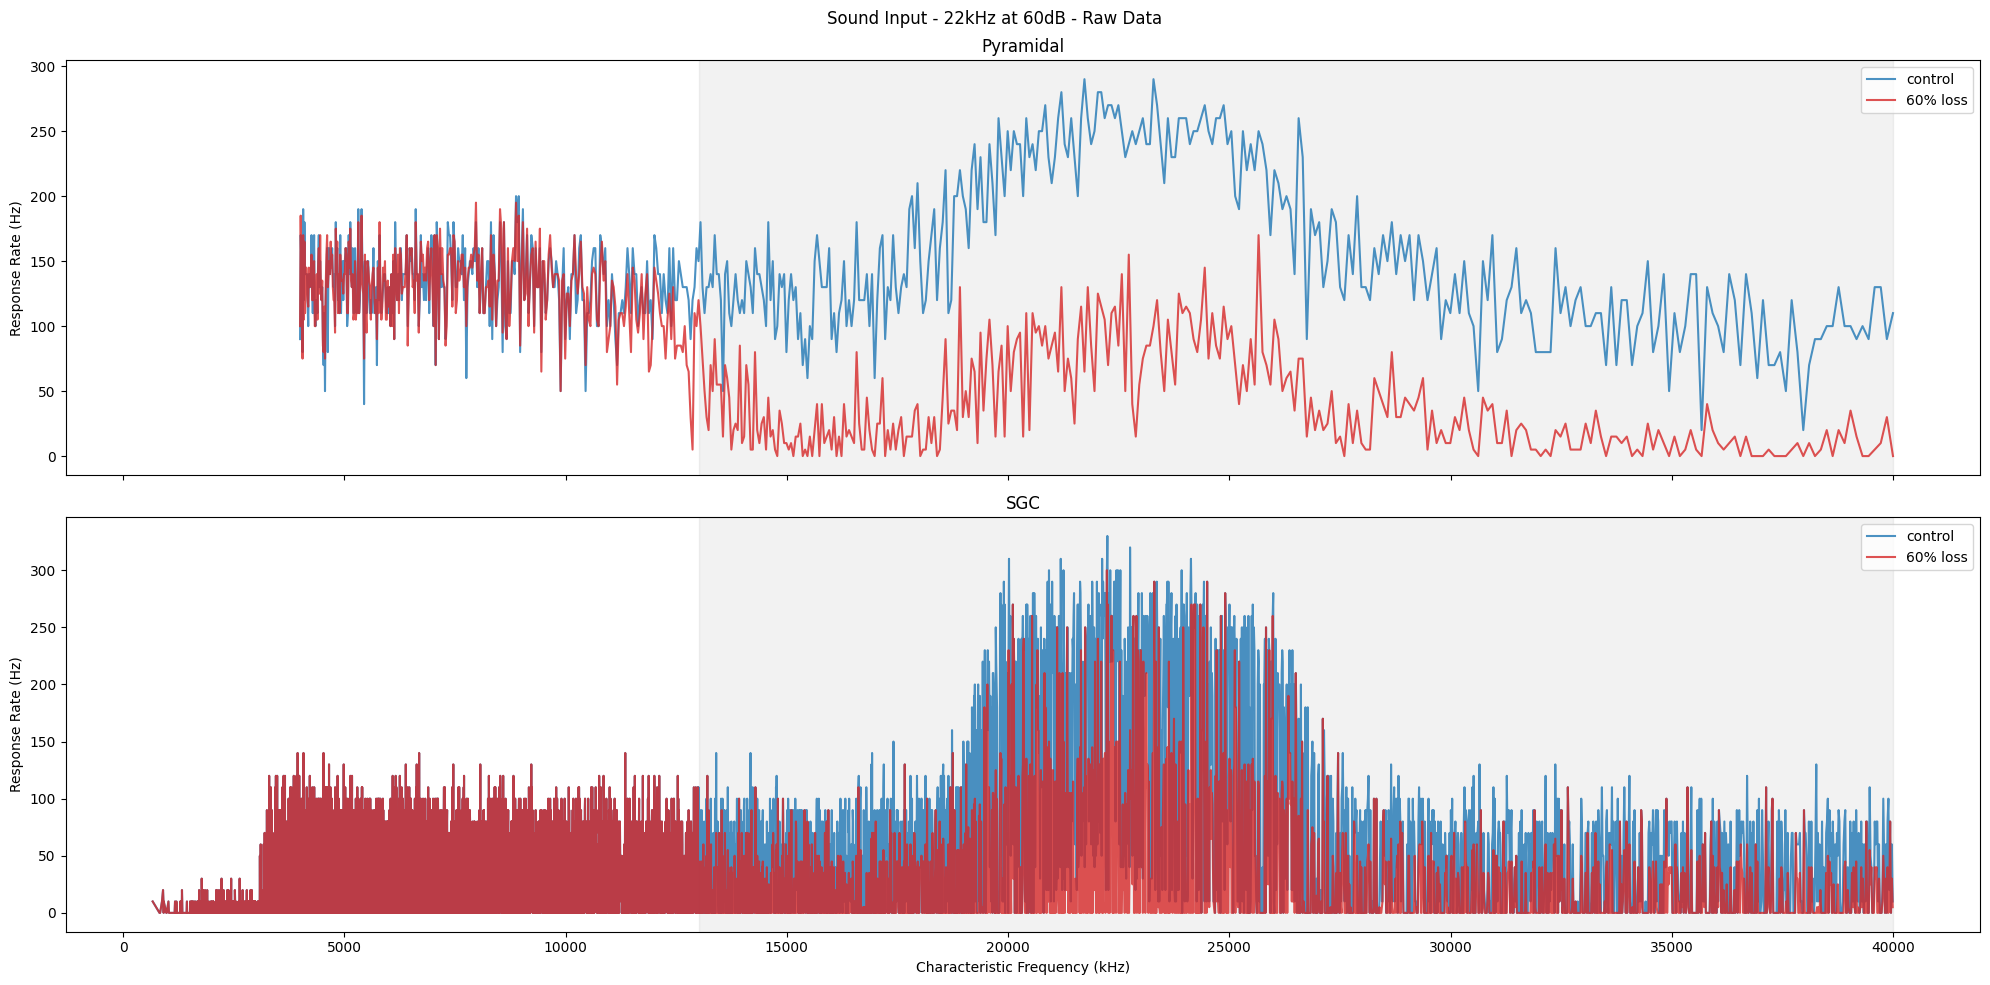

In [11]:
fig, axs = plt.subplots(2,1,figsize=(20,10), sharex=True)  #, sharey=True)
axs = axs.ravel()

data = (sgc_resp_spikes / (stimpar['response'][1] - stimpar['response'][0])*1000) - sgc_spont_rates*0
# data = sgc_resp_msfs
axs[1].plot(sgc_cfs[sgc_ids], data, color='tab:blue', zorder=13, alpha=0.8, label='control')
axs[1].set_title('SGC (control)')

data = (sgc_resp_spikes_loss / (stimpar['response'][1] - stimpar['response'][0])*1000) - sgc_spont_rates_loss*0 
# data = sgc_resp_msfs_loss
axs[1].plot(sgc_cfs[sgc_ids_loss], data, color='tab:red', zorder=13, alpha=0.8, label=f'{loss_frac}% loss')
axs[1].set_title(f"SGC")

data = (pyr_resp_spikes / (stimpar['response'][1] - stimpar['response'][0])*1000)-pyr_spont_rates*0 
# data = pyr_resp_msfs
axs[0].plot(freqs, data, color='tab:blue', zorder=13, alpha=0.8, label='control')

data = (pyr_resp_spikes_loss / (stimpar['response'][1] - stimpar['response'][0])*1000)-pyr_spont_rates_loss*0 
# data = pyr_resp_msfs_loss
axs[0].plot(freqs_loss, data, color='tab:red', zorder=13, alpha=0.8, label=f'{loss_frac}% loss')
axs[0].set_title(f'Pyramidal')

# axs[1,0].set_ylabel('Smoothed MSF')

loss_inds = np.array(freqs)[np.where(np.array(freqs) > 13e3)[0]]

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')

axs[0].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
axs[1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Response Rate (Hz)')
axs[1].set_ylabel('Response Rate (Hz)')

axs[1].set_xlabel('Characteristic Frequency (kHz)')
axs[1].set_xlabel('Characteristic Frequency (kHz)')

# fig.suptitle(f'Pyramidal Response to {input_freq}Hz at {input_level}dB (85 hearing loss starting at 13kHz)')
fig.suptitle(f"Sound Input - {round(input_freq/1000)}kHz at {input_level}dB - Raw Data")
fig.tight_layout()

## Normal vs Loss with IC - 22kHz at 60dB

In [6]:
stimpar = {
    "dur": 0.26,
    "pip": 0.1,
    "start": [0.1],
    "baseline": [50, 100],
    "response": [100, 200],
}

input_freq = 22e3
input_level = 60

### 60% Loss

In [13]:
n_cfs = 665
n_reps = 2

sim_flag = 'network_ds2v'

results = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}_ic/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}_ic/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
pyr_ids = list(itertools.chain.from_iterable(pyr_ids_per_band.values()))
freqs = list(pyr_ids_per_band.keys())
pyr_spont_rates = get_spontaneous_rate('pyramidal', results, stimpar, pyr_ids)
sgc_spont_rates = get_spontaneous_rate('sgc', results, stimpar)
pyr_ids, pyr_resp_spikes = get_cell_nspikes('pyramidal', results, stimpar['response'], pyr_ids)
sgc_ids, sgc_resp_spikes = get_cell_nspikes('sgc', results, stimpar['response'])

pyr_ids, pyr_resp_msfs = get_cell_msfs('pyramidal', results, stimpar['response'], pyr_ids)
sgc_ids, sgc_resp_msfs = get_cell_msfs('sgc', results, stimpar['response'])

n_cfs = 665  # 213 or 665
loss_frac = 60
loss_version = 'm3'
results_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}_13000loss-{loss_version}_{loss_frac}_ic/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}_13000loss-{loss_version}_{loss_frac}_ic/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
pyr_ids_loss = list(itertools.chain.from_iterable(pyr_ids_per_band_loss.values()))
freqs_loss = list(pyr_ids_per_band_loss.keys())
pyr_spont_rates_loss = get_spontaneous_rate('pyramidal', results_loss, stimpar, pyr_ids_loss)
sgc_spont_rates_loss = get_spontaneous_rate('sgc', results_loss, stimpar)
pyr_ids_loss, pyr_resp_spikes_loss = get_cell_nspikes('pyramidal', results_loss, stimpar['response'], pyr_ids_loss)
sgc_ids_loss, sgc_resp_spikes_loss = get_cell_nspikes('sgc', results_loss, stimpar['response'])

pyr_ids_loss, pyr_resp_msfs_loss = get_cell_msfs('pyramidal', results_loss, stimpar['response'], pyr_ids_loss)
sgc_ids_loss, sgc_resp_msfs_loss = get_cell_msfs('sgc', results_loss, stimpar['response'])

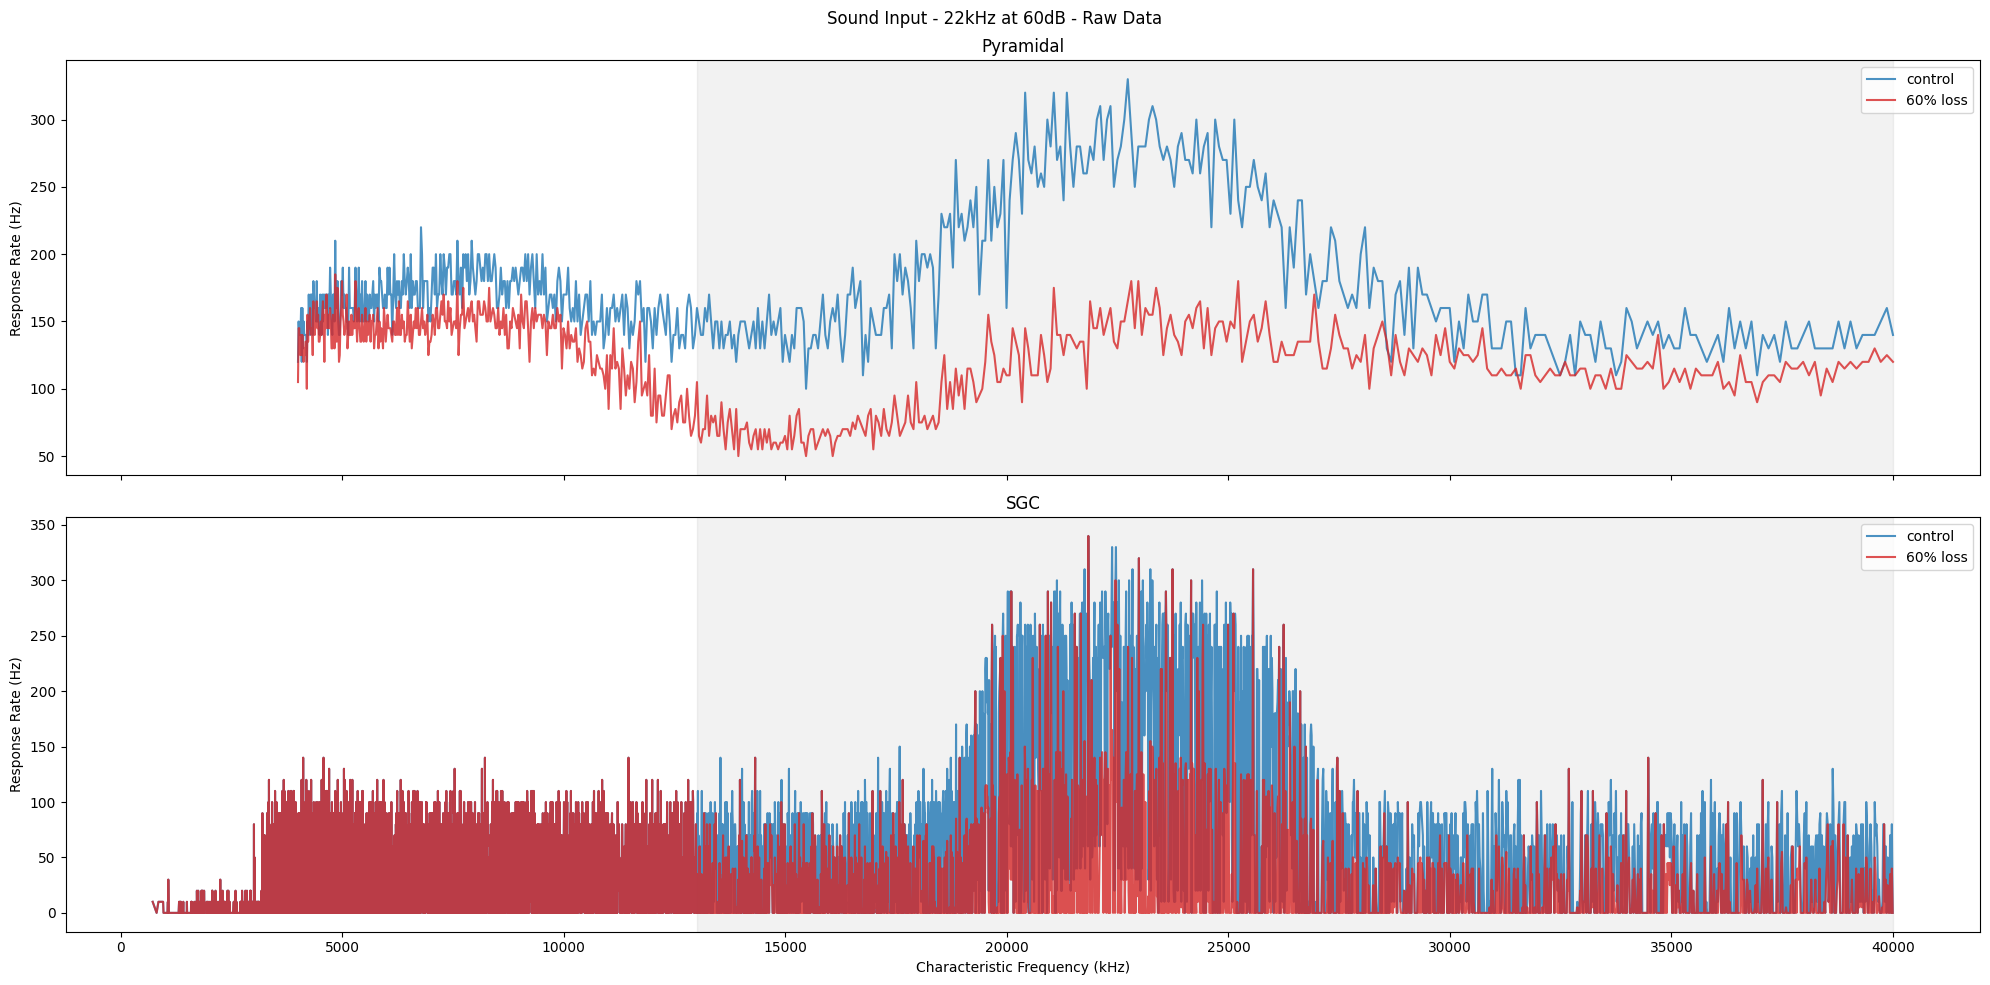

In [14]:
fig, axs = plt.subplots(2,1,figsize=(20,10), sharex=True)  #, sharey=True)
axs = axs.ravel()

data = (sgc_resp_spikes / (stimpar['response'][1] - stimpar['response'][0])*1000) - sgc_spont_rates*0
# data = sgc_resp_msfs
axs[1].plot(sgc_cfs[sgc_ids], data, color='tab:blue', zorder=13, alpha=0.8, label='control')
axs[1].set_title('SGC (control)')

data = (sgc_resp_spikes_loss / (stimpar['response'][1] - stimpar['response'][0])*1000) - sgc_spont_rates_loss*0 
# data = sgc_resp_msfs_loss
axs[1].plot(sgc_cfs[sgc_ids_loss], data, color='tab:red', zorder=13, alpha=0.8, label=f'{loss_frac}% loss')
axs[1].set_title(f"SGC")

data = (pyr_resp_spikes / (stimpar['response'][1] - stimpar['response'][0])*1000)-pyr_spont_rates*0 
# data = pyr_resp_msfs
axs[0].plot(freqs, data, color='tab:blue', zorder=13, alpha=0.8, label='control')

data = (pyr_resp_spikes_loss / (stimpar['response'][1] - stimpar['response'][0])*1000)-pyr_spont_rates_loss*0 
# data = pyr_resp_msfs_loss
axs[0].plot(freqs_loss, data, color='tab:red', zorder=13, alpha=0.8, label=f'{loss_frac}% loss')
axs[0].set_title(f'Pyramidal')

# axs[1,0].set_ylabel('Smoothed MSF')

loss_inds = np.array(freqs)[np.where(np.array(freqs) > 13e3)[0]]

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')

axs[0].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
axs[1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Response Rate (Hz)')
axs[1].set_ylabel('Response Rate (Hz)')

axs[1].set_xlabel('Characteristic Frequency (kHz)')
axs[1].set_xlabel('Characteristic Frequency (kHz)')

# fig.suptitle(f'Pyramidal Response to {input_freq}Hz at {input_level}dB (85 hearing loss starting at 13kHz)')
fig.suptitle(f"Sound Input - {round(input_freq/1000)}kHz at {input_level}dB - Raw Data")
fig.tight_layout()

### 50% Loss

In [10]:
n_cfs = 665
n_reps = 2

sim_flag = 'network_ds2v_ic'

results = pickle.load(open(f'/scratch/kedoxey/dcnmodel_scratch/output/response_maps-{sim_flag}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/scratch/kedoxey/dcnmodel_scratch/output/response_maps-{sim_flag}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
pyr_ids = list(itertools.chain.from_iterable(pyr_ids_per_band.values()))
freqs = list(pyr_ids_per_band.keys())
pyr_spont_rates = get_spontaneous_rate('pyramidal', results, stimpar, pyr_ids)
sgc_spont_rates = get_spontaneous_rate('sgc', results, stimpar)
pyr_ids, pyr_resp_spikes = get_cell_nspikes('pyramidal', results, stimpar['response'], pyr_ids)
sgc_ids, sgc_resp_spikes = get_cell_nspikes('sgc', results, stimpar['response'])

pyr_ids, pyr_resp_msfs = get_cell_msfs('pyramidal', results, stimpar['response'], pyr_ids)
sgc_ids, sgc_resp_msfs = get_cell_msfs('sgc', results, stimpar['response'])

n_cfs = 665  # 213 or 665
loss_frac = 50
loss_version = 'm3'
results_loss = pickle.load(open(f'/scratch/kedoxey/dcnmodel_scratch/output/response_maps-{sim_flag}_13000loss-{loss_version}_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band_loss = pickle.load(open(f'/scratch/kedoxey/dcnmodel_scratch/output/response_maps-{sim_flag}_13000loss-{loss_version}_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
pyr_ids_loss = list(itertools.chain.from_iterable(pyr_ids_per_band_loss.values()))
freqs_loss = list(pyr_ids_per_band_loss.keys())
pyr_spont_rates_loss = get_spontaneous_rate('pyramidal', results_loss, stimpar, pyr_ids_loss)
sgc_spont_rates_loss = get_spontaneous_rate('sgc', results_loss, stimpar)
pyr_ids_loss, pyr_resp_spikes_loss = get_cell_nspikes('pyramidal', results_loss, stimpar['response'], pyr_ids_loss)
sgc_ids_loss, sgc_resp_spikes_loss = get_cell_nspikes('sgc', results_loss, stimpar['response'])

pyr_ids_loss, pyr_resp_msfs_loss = get_cell_msfs('pyramidal', results_loss, stimpar['response'], pyr_ids_loss)
sgc_ids_loss, sgc_resp_msfs_loss = get_cell_msfs('sgc', results_loss, stimpar['response'])

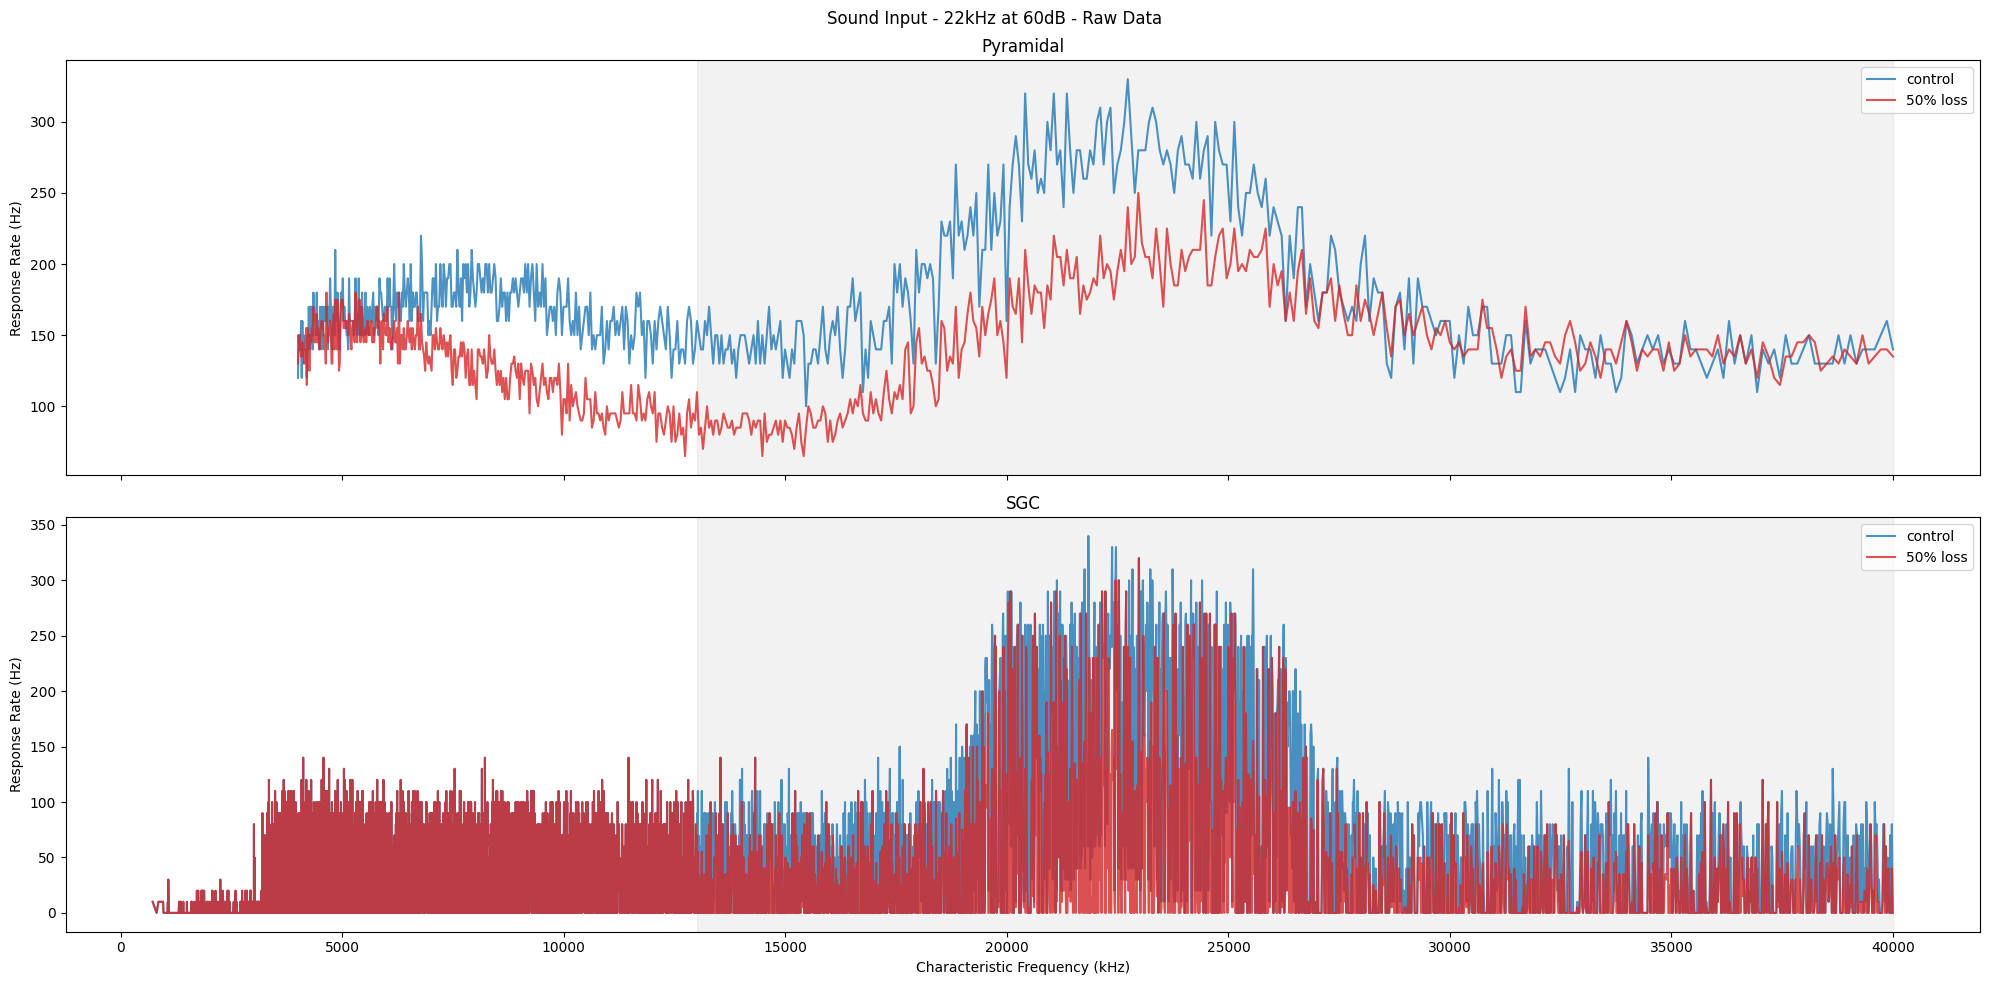

In [11]:
fig, axs = plt.subplots(2,1,figsize=(20,10), sharex=True)  #, sharey=True)
axs = axs.ravel()

data = (sgc_resp_spikes / (stimpar['response'][1] - stimpar['response'][0])*1000) - sgc_spont_rates*0
# data = sgc_resp_msfs
axs[1].plot(sgc_cfs[sgc_ids], data, color='tab:blue', zorder=13, alpha=0.8, label='control')
axs[1].set_title('SGC (control)')

data = (sgc_resp_spikes_loss / (stimpar['response'][1] - stimpar['response'][0])*1000) - sgc_spont_rates_loss*0 
# data = sgc_resp_msfs_loss
axs[1].plot(sgc_cfs[sgc_ids_loss], data, color='tab:red', zorder=13, alpha=0.8, label=f'{loss_frac}% loss')
axs[1].set_title(f"SGC")

data = (pyr_resp_spikes / (stimpar['response'][1] - stimpar['response'][0])*1000)-pyr_spont_rates*0 
# data = pyr_resp_msfs
axs[0].plot(freqs, data, color='tab:blue', zorder=13, alpha=0.8, label='control')

data = (pyr_resp_spikes_loss / (stimpar['response'][1] - stimpar['response'][0])*1000)-pyr_spont_rates_loss*0 
# data = pyr_resp_msfs_loss
axs[0].plot(freqs_loss, data, color='tab:red', zorder=13, alpha=0.8, label=f'{loss_frac}% loss')
axs[0].set_title(f'Pyramidal')

# axs[1,0].set_ylabel('Smoothed MSF')

loss_inds = np.array(freqs)[np.where(np.array(freqs) > 13e3)[0]]

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')

axs[0].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
axs[1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Response Rate (Hz)')
axs[1].set_ylabel('Response Rate (Hz)')

axs[1].set_xlabel('Characteristic Frequency (kHz)')
axs[1].set_xlabel('Characteristic Frequency (kHz)')

# fig.suptitle(f'Pyramidal Response to {input_freq}Hz at {input_level}dB (85 hearing loss starting at 13kHz)')
fig.suptitle(f"Sound Input - {round(input_freq/1000)}kHz at {input_level}dB - Raw Data")
fig.tight_layout()

### 40% Loss

In [11]:
n_cfs = 665
n_reps = 2

sim_flag = 'network_ds2v_ic'

results = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
pyr_ids = list(itertools.chain.from_iterable(pyr_ids_per_band.values()))
freqs = list(pyr_ids_per_band.keys())
pyr_spont_rates = get_spontaneous_rate('pyramidal', results, stimpar, pyr_ids)
sgc_spont_rates = get_spontaneous_rate('sgc', results, stimpar)
pyr_ids, pyr_resp_spikes = get_cell_nspikes('pyramidal', results, stimpar['response'], pyr_ids)
sgc_ids, sgc_resp_spikes = get_cell_nspikes('sgc', results, stimpar['response'])

pyr_ids, pyr_resp_msfs = get_cell_msfs('pyramidal', results, stimpar['response'], pyr_ids)
sgc_ids, sgc_resp_msfs = get_cell_msfs('sgc', results, stimpar['response'])

n_cfs = 665  # 213 or 665
loss_frac = 40
loss_version = 'm3'
results_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}_13000loss-{loss_version}_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}_13000loss-{loss_version}_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
pyr_ids_loss = list(itertools.chain.from_iterable(pyr_ids_per_band_loss.values()))
freqs_loss = list(pyr_ids_per_band_loss.keys())
pyr_spont_rates_loss = get_spontaneous_rate('pyramidal', results_loss, stimpar, pyr_ids_loss)
sgc_spont_rates_loss = get_spontaneous_rate('sgc', results_loss, stimpar)
pyr_ids_loss, pyr_resp_spikes_loss = get_cell_nspikes('pyramidal', results_loss, stimpar['response'], pyr_ids_loss)
sgc_ids_loss, sgc_resp_spikes_loss = get_cell_nspikes('sgc', results_loss, stimpar['response'])

pyr_ids_loss, pyr_resp_msfs_loss = get_cell_msfs('pyramidal', results_loss, stimpar['response'], pyr_ids_loss)
sgc_ids_loss, sgc_resp_msfs_loss = get_cell_msfs('sgc', results_loss, stimpar['response'])

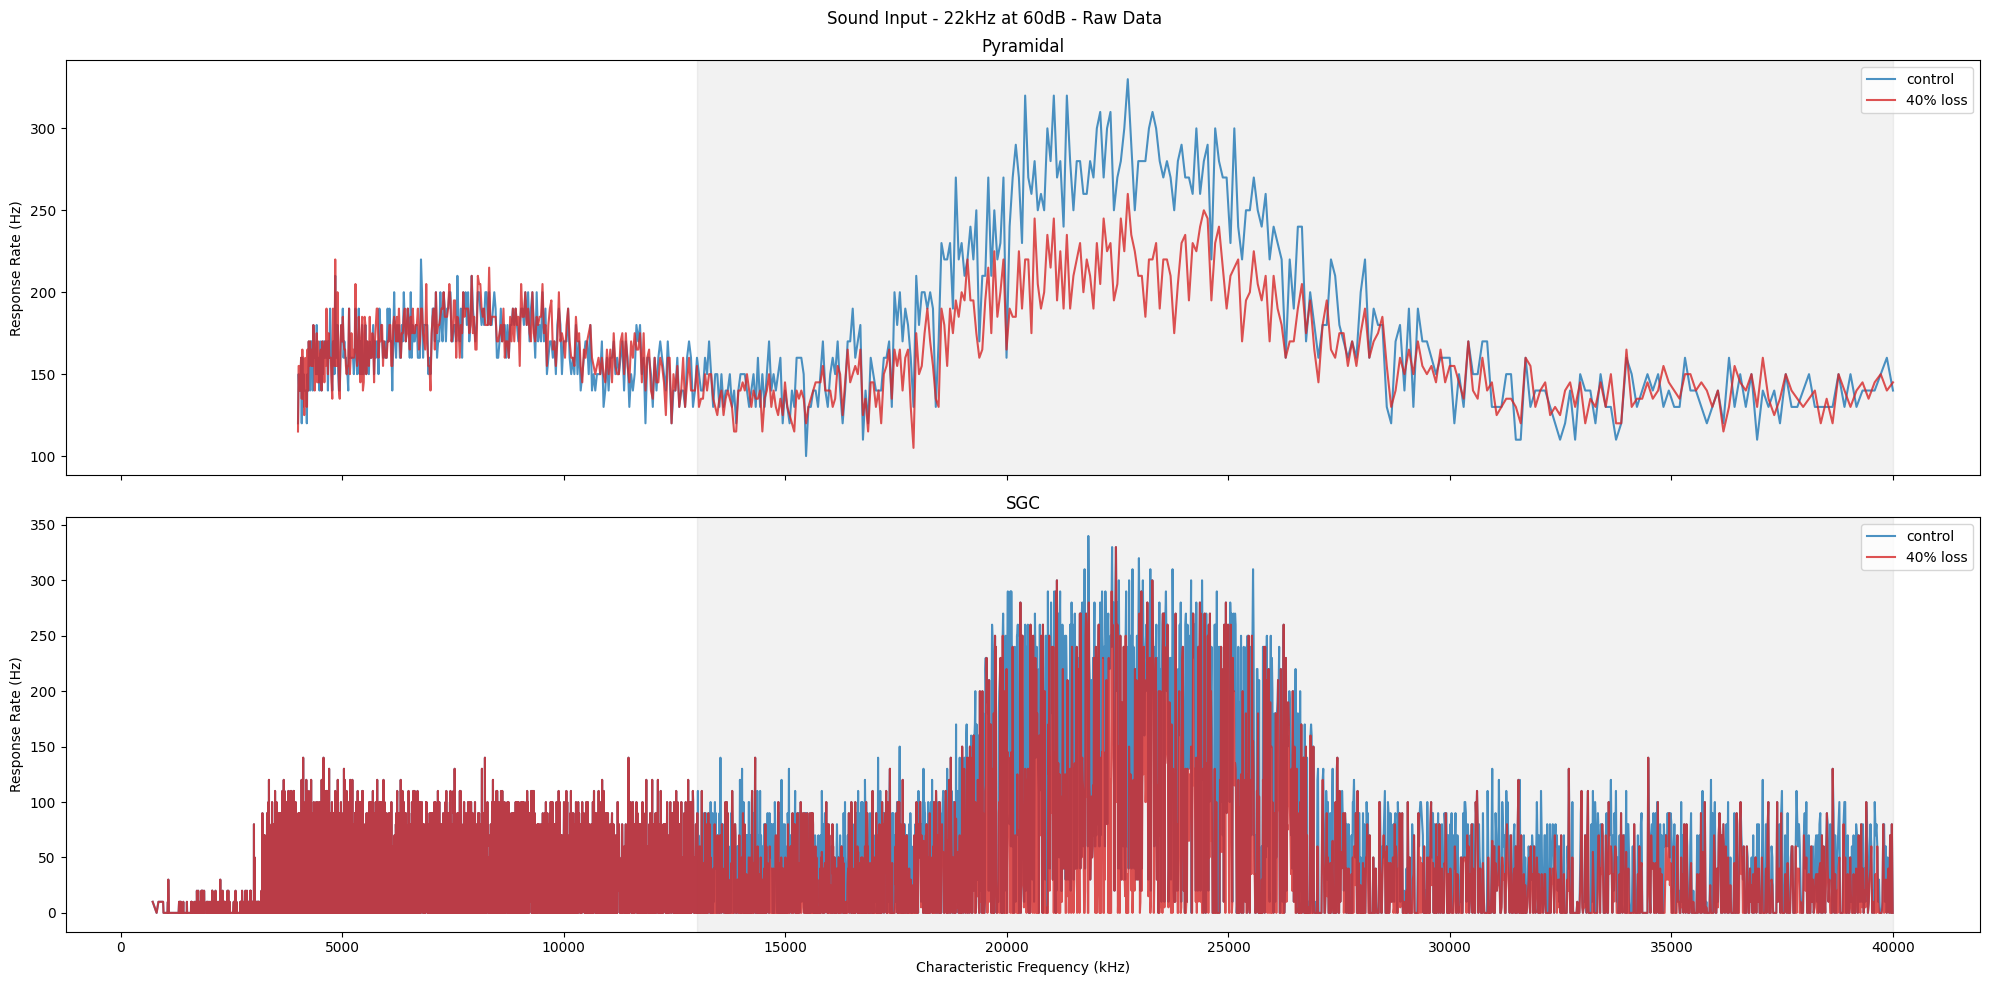

In [12]:
fig, axs = plt.subplots(2,1,figsize=(20,10), sharex=True)  #, sharey=True)
axs = axs.ravel()

data = (sgc_resp_spikes / (stimpar['response'][1] - stimpar['response'][0])*1000) - sgc_spont_rates*0
# data = sgc_resp_msfs
axs[1].plot(sgc_cfs[sgc_ids], data, color='tab:blue', zorder=13, alpha=0.8, label='control')
axs[1].set_title('SGC (control)')

data = (sgc_resp_spikes_loss / (stimpar['response'][1] - stimpar['response'][0])*1000) - sgc_spont_rates_loss*0 
# data = sgc_resp_msfs_loss
axs[1].plot(sgc_cfs[sgc_ids_loss], data, color='tab:red', zorder=13, alpha=0.8, label=f'{loss_frac}% loss')
axs[1].set_title(f"SGC")

data = (pyr_resp_spikes / (stimpar['response'][1] - stimpar['response'][0])*1000)-pyr_spont_rates*0 
# data = pyr_resp_msfs
axs[0].plot(freqs, data, color='tab:blue', zorder=13, alpha=0.8, label='control')

data = (pyr_resp_spikes_loss / (stimpar['response'][1] - stimpar['response'][0])*1000)-pyr_spont_rates_loss*0 
# data = pyr_resp_msfs_loss
axs[0].plot(freqs_loss, data, color='tab:red', zorder=13, alpha=0.8, label=f'{loss_frac}% loss')
axs[0].set_title(f'Pyramidal')

# axs[1,0].set_ylabel('Smoothed MSF')

loss_inds = np.array(freqs)[np.where(np.array(freqs) > 13e3)[0]]

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')

axs[0].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
axs[1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Response Rate (Hz)')
axs[1].set_ylabel('Response Rate (Hz)')

axs[1].set_xlabel('Characteristic Frequency (kHz)')
axs[1].set_xlabel('Characteristic Frequency (kHz)')

# fig.suptitle(f'Pyramidal Response to {input_freq}Hz at {input_level}dB (85 hearing loss starting at 13kHz)')
fig.suptitle(f"Sound Input - {round(input_freq/1000)}kHz at {input_level}dB - Raw Data")
fig.tight_layout()